# Scalability

In [4]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sql_f
import pandas as pd

TOTAL_RAM = "2g" 
MODEL_NAME = "Scalability"

spark = SparkSession.builder \
    .appName(MODEL_NAME) \
    .master("local[*]") \
    .config("spark.driver.memory", TOTAL_RAM) \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.2") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

sc = spark.sparkContext

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/09 08:07:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Speed Up

Since in this machine our CPU only has 4 cores, we will measure entirety of the dataset (100%) with each number of cores.

```python
spark = SparkSession.builder \
        .appName(MODEL_NAME) \
        .master(f"local[{cores}]") \
```

In [1]:
num_cores = [2, 3, 4]

for i in range(5):
    for cores in num_cores:
        print(f'Analysing with {cores} ')
        !python code/scalability_global.py {cores} 100 speedup_random_forest.csv


Analysing with 2 

--- STARTING: DecisionTree_cores2_pct100 ---

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/09 00:11:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/01/09 00:11:40 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in standalone/kubernetes and LOCAL_DIRS in YARN).
1. Loading Data...
   Features (26): ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP']... (showing first 5)
   Assembling features...

2. Training DecisionTree_cores2_pct100...
   Training completed in 1403.17 seconds.                                       

4. Evaluating on Validation Set...
   Validation RMSE: 0.1046                                                      
   Validat

In [2]:
def speed_up(results, runtime_col):
    return results[runtime_col].iloc[0] / results[runtime_col]

In [5]:
results = pd.read_csv('scalability_results/speedup_dt.csv', 
                      names=['cores', 'pct', 'total_runtime', 'train_count', 'rmse', 'r2'])

grouped = results.groupby('cores')
avg_results = grouped.mean()
std = grouped.std()
avg_results['speed-up'] = speed_up(avg_results, 'total_runtime')

avg_results


,pct,total_runtime,train_count,rmse,r2,speed-up
cores,,,,,,
1,100.0,964.876905,60642470.0,0.100324,0.987827,1.000000
2,100.0,612.432025,60642470.0,0.096782,0.988671,1.575484
3,100.0,442.576333,60642470.0,0.100569,0.987767,2.180137
4,100.0,369.518097,60642470.0,0.098201,0.988336,2.611176


In [6]:
from matplotlib import pyplot as plt

def plot_scalability_measure(name, stats, xlabel, x_vals, linear_vals):
    # Create the plot with single subplot
    fig, ax = plt.subplots(figsize=(6, 4))
    fig.suptitle(
        f"{name.capitalize()} of a PySpark ML model with Decision Trees"
    )
    
    # Plot the measure
    ax.plot(x_vals, stats[name], "ko-", label=f"Real {name}")
    
    # Plot the linear values for the measure
    ax.plot(x_vals, linear_vals, "--", color="gray",
            label=f"Linear {name}", linewidth=1)
    
    ax.set(xlabel=xlabel, ylabel=name.capitalize())
    
    if name == "scale-up":
        ax.set_ylim([0, 1.1])
    
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()

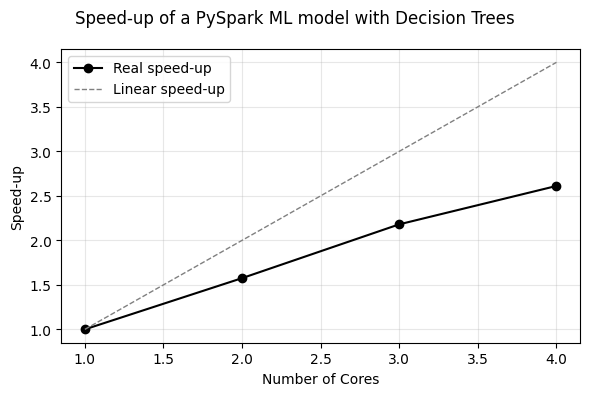

In [7]:
x_vals = avg_results.index.values
linear_vals = x_vals  # Linear speedup
plot_scalability_measure('speed-up', avg_results, 'Number of Cores', x_vals, linear_vals)
plt.show()

## Size Up

How we do the division:
```python
df_train.sample(withReplacement=False, fraction=pct/100.0, seed=42)
```

We wont re-execute with the value '100' because we already executed the 100% of data with 4 cores on the Speed-Up part, and to make the execution of the whole notebook more efficient we will just take the results from the previous experiment in that row.


In [ ]:
sizes = [10, 25, 50, 75] 

for i in range(5):
    for fraction in sizes:
        !python code/scalability_global.py 4 {fraction} sizeup_random_forest.csv  


--- STARTING: DecisionTree_cores4_pct10 ---

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/08 15:34:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
1. Loading Data...
   Features (26): ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP']... (showing first 5)
   Sampling 10% of total universe...
   Assembling features...
   Training Rows: 6,066,609                                                     
   Partitions: 4=====================================>              (6 + 2) / 8]

2. Training DecisionTree_cores4_pct10...
   Training completed in 32.88 seconds.                                         

4. Evaluating on Validation Set...
   Validation RMSE: 0.1002                                                      
   Validation R2: 0.98

In [8]:
def size_up(results, runtime_col):
    return results[runtime_col] / results[runtime_col].iloc[0]

In [16]:
model = "dt" # or "rf"  

speedup = pd.read_csv(
    f'scalability_results/speedup_{model}.csv', 
    names=['cores', 'pct', 'total_runtime', 'train_count', 'rmse', 'r2']
)
speedup['pct'] = 100  # ensure size column exists

speedup_4cores = speedup[speedup['cores'] == 4]

sizeup = pd.read_csv(
    f'scalability_results/sizeup_{model}.csv', 
    names=['cores', 'pct', 'total_runtime', 'train_count', 'rmse', 'r2']
)
sizeup['cores'] = 4  # ensure cores column exists


# Combine all data
all_results = pd.concat([sizeup, speedup_4cores], ignore_index=True)

grouped = all_results.groupby(['pct'])
avg_results = grouped.mean()
std = grouped.std()
avg_results['size-up'] = size_up(avg_results, 'total_runtime')

avg_results


,cores,total_runtime,train_count,rmse,r2,size-up
pct,,,,,,
10,4.0,37.822408,6066609.0,0.100197,0.987857,1.000000
25,4.0,105.661215,15166460.0,0.099661,0.987987,2.793614
50,4.0,218.661935,30325970.0,0.099749,0.987966,5.781280
75,4.0,310.538369,45484496.0,0.100318,0.987828,8.210434
100,4.0,369.518097,60642470.0,0.098201,0.988336,9.769819


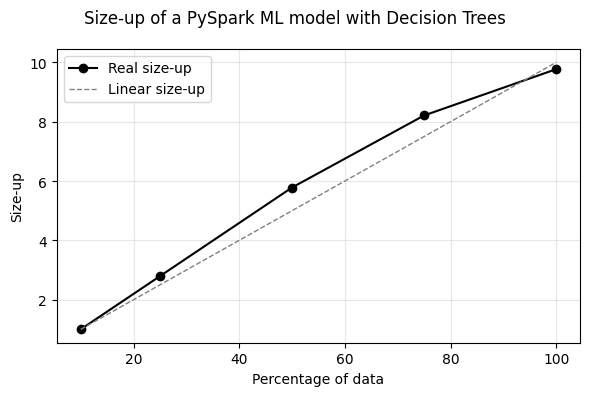

In [18]:
x_vals = avg_results.index.values
linear_vals = x_vals / x_vals[0] # Linear sizeup
plot_scalability_measure('size-up', avg_results, 'Percentage of data', x_vals, linear_vals)
plt.show()

## Scale Up

The options with 4 cores and the 100% of data have already been tested and got it speedup and sizeup, so we wont rerun those

| Cores \ Size | 25         | 50         | 75         | 100        |
|--------------|------------|------------|------------|------------|
| 1            | ❌ New     | ❌ New     | ❌ New     | ✅ Speedup |
| 2            | ❌ New     | ❌ New     | ❌ New     | ✅ Speedup |
| 3            | ❌ New     | ❌ New     | ❌ New     | ✅ Speedup |
| 4            | ✅ Sizeup  | ✅ Sizeup  | ✅ Sizeup  | ✅ Speedup   |


In [22]:
num_cores = [1, 2, 3, 4]
sizes = [25, 50, 75, 100]

In [ ]:
for i in range(5):
    for j in range(len(num_cores)):
        for k in range(len(sizes)):
            !python code/scalability_global.py {num_cores[j]} \
                                    {sizes[k]} scaleup_random_forest.csv

In [19]:
def scale_up(results, runtime_col):
    return results[runtime_col].iloc[0] / results[runtime_col]

In [25]:
model = "dt" # or "rf" 
# Load all three datasets
speedup = pd.read_csv(
    f'scalability_results/speedup_{model}.csv', 
    names=['cores', 'pct', 'total_runtime', 'train_count', 'rmse', 'r2']
)
speedup['pct'] = 100  # ensure size column exists

sizeup = pd.read_csv(
    f'scalability_results/sizeup_{model}.csv', 
    names=['cores', 'pct', 'total_runtime', 'train_count', 'rmse', 'r2']
)
sizeup['cores'] = 4  # ensure cores column exists

scaleup = pd.read_csv(
    f'scalability_results/scaleup_{model}.csv', 
    names=['cores', 'pct', 'total_runtime', 'train_count', 'rmse', 'r2']
)

# Combine all data
all_results = pd.concat([speedup, sizeup, scaleup], ignore_index=True)

grouped = all_results.groupby(['cores','pct'])
avg_results = grouped.mean()
std = grouped.std()
avg_results['scale-up'] = scale_up(avg_results, 'total_runtime')

points = [(1, 25), (2, 50), (3, 75), (4, 100)]
df_scale = avg_results.loc[points].copy()
df_scale['scale-up'] = df_scale['total_runtime'].iloc[0] / df_scale['total_runtime']

df_scale

,,total_runtime,train_count,rmse,r2,scale-up
cores,pct,,,,,
1,25,182.039168,15166460.0,0.098209,0.988334,1.000000
2,50,314.981701,30325970.0,0.097474,0.988508,0.577936
3,75,340.105884,45484496.0,0.100169,0.987864,0.535243
4,100,369.518097,60642470.0,0.098201,0.988336,0.492639


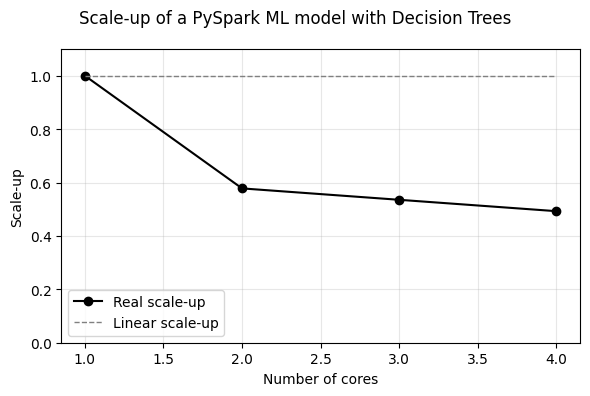

In [28]:
ideal_scaleup = [1] * len(num_cores)
plot_scalability_measure('scale-up', df_scale, 'Number of cores',
                         num_cores, ideal_scaleup)